# Türkçe Metinlerde Konu Tahmini
### Gerekli Kütüphaneler

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import warnings
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### Verisetimizi indirelim

In [5]:
#verinin tanımlanması
data = pd.read_excel('topic_modeling.xlsx')
data.head() # İlk  örnek

,Class,Document
0,astronomi,NGC 5713 Başak takımyıldızı bölgesinde bulunan...
1,astronomi,Birçok katalogda sarmal gökada olarak sınıflan...
2,hükümet,"Corina Casanova , İsviçre Federal Şansölyesidir ."
3,yasa,"Casanova , İsviçre Federal Yüksek Mahkemesi es..."
4,hükümet,Corina Casanova bir federal parlementerdir .


In [6]:
#veriye ön bakış
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647809 entries, 0 to 647808
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Class     647809 non-null  object
 1   Document  647809 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


### 647.809 adet veri bulunmakta ve 49 adet etikete sahip.

In [7]:
#etiketlerin elde edilmesi
class_ = Counter(data['Class']).keys()
class_

dict_keys(['astronomi', 'hükümet', 'yasa', 'bölge', 'televizyon', 'bilgisayar', 'işletme', 'film', 'tıp', 'askeri', 'zaman', 'organizasyon', 'spor', 'futbol', 'inşaat', 'coğrafya', 'müzik', 'oyunlar', 'insanlar', 'kraliyet hanedanı', 'eğitim', 'ödül', 'biyoloji', 'internet', 'simgeler', 'kitaplar', 'ortak_medya', 'görsel_sanat', 'travel', 'kurgusal_evren', 'havacılık', 'ulaşım', 'kimya', 'dil', 'finans', 'otomotiv', 'opera', 'çizgiromanlar', 'basketbol', 'yemek', 'interests', 'tiyatro', 'din', 'ölçü_birimi', 'moda', 'meteoroloji', 'mühendislik', 'exhibitions', 'fizik'])

### Her etiketten veri içerisinde kaç tane var

In [8]:
#etiketlerin içerisindeki veri sayıları
sum_ = Counter(data['Class']).values()
sum_

dict_values([4997, 19921, 3083, 89926, 20612, 7366, 8258, 42623, 12107, 21378, 11146, 14847, 32363, 8560, 5023, 7340, 53235, 5685, 129943, 7683, 8423, 14214, 18917, 2357, 5160, 21726, 6155, 3984, 3552, 7883, 3982, 4156, 4696, 5352, 942, 2448, 4125, 1782, 3721, 4222, 1479, 2101, 6734, 1228, 460, 212, 1078, 129, 495])

### Etiket Sayılarının Grafiksel Gösterimi

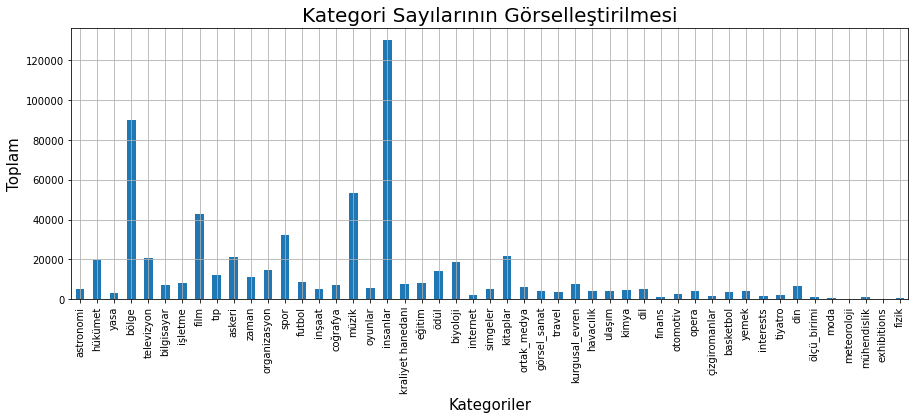

In [9]:
#elde edilen etiketlerin ve içerdiği sayıları görselleştirmek için dataframe yapısına çeviriyoruz.
df = pd.DataFrame(zip(class_,sum_), columns = ['Class', 'Toplam'])
#etiketlerin görselleştirilmesi - çubuk grafiği
df.plot(x = 'Class' , y = 'Toplam',kind = 'bar', legend = False, grid = True, figsize = (15,5))
plt.title('Kategori Sayılarının Görselleştirilmesi', fontsize = 20)
plt.xlabel('Kategoriler', fontsize = 15)
plt.ylabel('Toplam', fontsize = 15);

### Pasta Grafiği

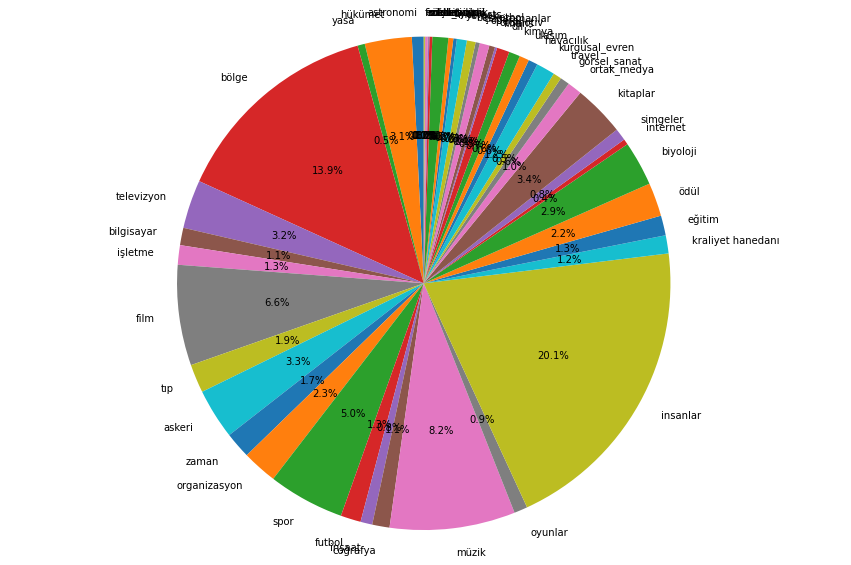

In [10]:
#etiketlerin görselleştirilmesi - pasta grafiği
fig, ax = plt.subplots(figsize=(15, 10))
ax.pie(df.Toplam, labels =df.Class, autopct = '%1.1f%%',  startangle = 90 )
ax.axis('equal')
plt.show()

### Şimdi veriye biraz önişleme metotları uygulayarak noktalama işaretlerini ve günlük hayatta çok fazla kullanılan ama tek başına bir anlam ifade etmeyen **stopwords** olarak adlandırdığımız kelimeleri kaldıralım ve bütün metinlerimizi küçültelim. Bu sayede elimizde kullanabileceğimiz daha temiz ve düzenli bir veri olacaktır.

In [12]:
#Burada nltk kütüphanesinde bulunan Türkçe stopword'leri bir değişkene atıyoruz.
WPT = nltk.WordPunctTokenizer()
stop_word_list = nltk.corpus.stopwords.words('turkish')
#Daha sonra verimizdeki noktalama işaretlerini kaldırıp stopword'lerden arındırıyoruz.
docs = data['Document']
docs = docs.map(lambda x: re.sub('[,\.!?();:$%&#"]', '', x))
docs = docs.map(lambda x: x.lower())
docs = docs.map(lambda x: x.strip())
#stopword'leri kaldırıyoruz buradaki fonksiyon ile
def token(values):
    filtered_words = [word for word in values.split() if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc
docs = docs.map(lambda x: token(x))
data['Document'] = docs
print(data.head(20))

         Class                                           Document
0    astronomi  ngc 5713 başak takımyıldızı bölgesinde bulunan...
1    astronomi  birçok katalogda sarmal gökada olarak sınıflan...
2      hükümet     corina casanova i̇sviçre federal şansölyesidir
3         yasa  casanova i̇sviçre federal yüksek mahkemesi esk...
4      hükümet         corina casanova bir federal parlementerdir
5        bölge  casanova hristiyan demokrat halk partisi üyesi...
6      hükümet  i̇sviçre dışişleri bakanlığı i̇sviçre federal ...
7      hükümet  i̇sviçre'nin dış ilişkilerini sürdürmekle göre...
8        bölge  gilgit baltistan pakistan kuzey bölgeler urduc...
9        bölge  72496 km alan kaplamakta oldukça dağlık bir ar...
10       bölge                       bölgesel başkenti gilgit'dir
11       bölge  urduca peştuca wakhi shina balti khuar buruşas...
12       bölge  denton amerika birleşik devletleri'nde teksas ...
13       bölge  coğrafî olarak oklahoma teksas sınırının 61 ki...
14       b

### Verimizi tahminleme yapmak için sayısal veri haline getirmemiz gerekiyor. Tfidf skorlama yöntemini kullanarak veriyi sayısallaştırmadan önce test ve train olarak veriyi ayırıyoruz.

In [13]:
dataDoc = data['Document'].values.tolist()
dataClass = data['Class'].values.tolist()
#test ve train olarak verinin ayrılması
x_train, x_test, y_train, y_test = train_test_split(dataDoc, dataClass, test_size = 0.3, random_state = 42)
#tfidf işlemi
## max_df 0,9 tfidf skorundan fazla olanları kelimeleri alma
## min_df 5 frekansından düşük olan kelimeleri alma
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

### Tfidf skorlama yöntemi dokümanda sıkça geçen kelimelerin baskın olması ve dokümanı temsil etmesinin önüne geçilmesini sağlar. Burada n_gram_range olarak unigram ve bigram yani tekli ve ikili kelimeleri göz önüne almasını istedim, max_df ve min_df ise kelime dağarcığı oluştururken kelimelerin metinde geçen sıklığına göre ayarlama yapılmasıdır.

### Train datası olarak ayırdığımız veride en fazla geçen ilk 20 kelimeye bakalım.

In [14]:
words_counts = Counter([word for line in x_train for word in line.split(' ')])
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:20]
most_common_words[:20]

[('bir', 121182),
 ('olarak', 48115),
 ('olan', 39859),
 ('yılında', 30484),
 ('tarafından', 24377),
 ('sonra', 23792),
 ('ilk', 23313),
 ('büyük', 16955),
 ('yer', 15010),
 ('arasında', 12783),
 ('oldu', 12070),
 ('kadar', 11815),
 ('the', 11342),
 ('2', 10580),
 ('iki', 10370),
 ('bulunan', 9993),
 ('aynı', 9876),
 ('1', 9866),
 ('dünya', 9489),
 ('adlı', 9265)]

### Denetimli Tahminleme Yöntemi
### Artık verimiz tahminleme yapmak için hazır. Ben önce OneVsRest çatı modelini kullanarak üç adet denetimli modelde tahminleme yaptım ve her birinin başarı oranını karşılaştırdım. Burada kullandığım modeller **Lojistik Regresyon, LineerSVC ve Stochastic Gradient Descent**. Modelleri seçerken herhangi bir özel sebebim yok tamamen rastgele bu modelleri seçip tahminleme yaptım. Tabi daha iyi sonuçlar veren modeller olacaktır.

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
#logistic regresyon
model = OneVsRestClassifier(LogisticRegression(penalty = 'l2', C=1.0))
model.fit(x_train_tfidf, y_train)
print ("Logistic Regression Accuracy={}".format(accuracy_score(y_test, model.predict(x_test_tfidf))))
logisticpred = accuracy_score(y_test, model.predict(x_test_tfidf))
#stochastic gradient descent
model2 = OneVsRestClassifier(SGDClassifier(loss = 'hinge', penalty = 'elasticnet', max_iter = 5))
model2.fit(x_train_tfidf, y_train)
print ("SGD Accuracy={}".format(accuracy_score(y_test, model2.predict(x_test_tfidf))))
sgdpred = accuracy_score(y_test, model2.predict(x_test_tfidf))
#lineersvc
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
SVC_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
SVC_pipeline.fit(x_train_tfidf, y_train)
prediction = SVC_pipeline.predict(x_test_tfidf)
print('LineerSVC accuracy is {}'.format(accuracy_score(y_test, prediction)))

/home/enespolat/anaconda3/envs/pypq/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/enespolat/anaconda3/envs/pypq/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/sta

Logistic Regression Accuracy=0.6035411617603927


/home/enespolat/anaconda3/envs/pypq/lib/python3.6/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGD Accuracy=0.45848834277540224
LineerSVC accuracy is 0.645472180629094


In [17]:
lineersvcpred=accuracy_score(y_test,SVC_pipeline.predict(x_test_tfidf))

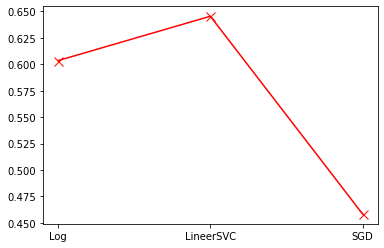

In [18]:
#test accuracy'lerinin görselleştirilmesi
accuracys = [logisticpred,lineersvcpred,sgdpred]
plt.plot(["Log", "LineerSVC", "SGD"],accuracys , marker = "x" , markersize = 9 , color = "red");

### Denetimsiz Tahminleme Yöntemi
### Görmüş olduğunuz gibi modellerin başarısı biraz düşük kaldı, özellikle stochastic gradient descent modeli çok düşük bir tahmin başarısı gösterdi. Tabi bu verinin büyüklüğü ya da model parametrelerinin daha iyi ayarlanmasıyla yükseltilebilir ya da başka modeller deneyerek veri için daha uygun bir model bulunabilir. Gelin bir de denetimsiz model olan **Latent Dirichlet Allocation(LDA)** modeline bakalım.

### LDA modeli için veriyi CountVectorizer sınıfı ile uygun hale getiriyoruz. Daha sonra model parametrelerini ayarlayarak modeli eğitiyoruz. Burada ben modele 30 etiket vermesini söyledim ve 5 iterasyonda kendini en iyi şekilde eğitmesini söyledim. Verinin ilk 8 çıktısı aşağıda gördüğünüz gibi.

In [19]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
#denetimsiz olarak modeli tahmin etmek için countvectorizer ile train verisini sayısal hale getiriyoruz.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000)
tf = tf_vectorizer.fit_transform(dataDoc)
tf_feature_names = tf_vectorizer.get_feature_names()
#modelin oluşturulması
lda = LDA(n_components=30, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
display_topics(lda,tf_feature_names,30)

Topic 0:
bir küçük şekilde on iki talyan türü spor ilgili japon olur dizi kız amacıyla yerel idi filmidir oyuncusudur familyasından adam adında yahudi dizisi komedi verdiği kullanılır kitap çocuğu tamamen şeklinde
Topic 1:
nın dünya nda kupası savaşı ii yapılan sırasında kazandı gün pek şampiyonası doğru 1992 yaz nı fifa olimpiyatları yunanistan kinci karşı azerbaycan şampiyon madalya kulüp brezilya oyunları doğusunda altın stadyumu
Topic 2:
birlikte ye alman ocak uzun kısa 12 de temsil geniş arkadaşı parti tan lı asıllı para aktör halen eşi macaristan doğan yu von kısmı kodu kasım yalnızca bulundu destek yıllar
Topic 3:
da de oldu ya yeni ilk almanya başladı nın olarak sonunda ulusal grup kişi kurulan talya başkenti sahibi yaşında londra amerikalı girdi başlayan hollanda şehrinde 1986 düzenlenen polonya 1984 2014
Topic 4:
tarafından ikinci yılında şarkı üzere 2004 albümü albüm olmak çıkan sahiptir isimli rock sıra 1996 albümün stüdyo yanı ev ndan sanatçı şarkısı iç güzel yayınlandı ya

### Görselleştirmedeki ilk parametremiz oluşturmuş olduğumuz model, ikinci ve üçüncü parametreler CountVektorizer ile oluşturduğumuz kelime matrisimiz ve dördüncü parametrede hangi yöntemle çizeceğimizi belirtiyoruz.

### Gördüğünüz gibi tahmin edilen konuların içeriğinde hangi kelimelerin olduğunu ve konuların nasıl dağıldığını görebiliyoruz.

In [20]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda,tf, tf_vectorizer, mds = 'tsne' )

In [21]:
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
11     119.070190   64.655502       1        1  4.241549
3       54.382130  109.799164       2        1  4.215781
10    -161.423965 -103.744957       3        1  4.058919
14    -135.370758   36.673065       4        1  3.928254
8      177.317215  -66.872452       5        1  3.867865
4      -16.436356  142.453796       6        1  3.757854
6       31.052383  204.777573       7        1  3.735176
12     -25.024384 -186.083466       8        1  3.685046
1      -68.157486   20.934038       9        1  3.614834
27      -3.751695    4.961509      10        1  3.560858
0     -114.470009 -179.605469      11        1  3.552107
19    -110.729126  -40.476776      12        1  3.469674
7       42.552418  -42.789406      13        1  3.462227
25     -10.661536   71.922211      14        1  3.423457
23     112.652969  -16.279951      15        1  3.373644
15    -195.499146  -25.853945      16        1  3.250670
17    -207.165924   66.070419      17        1  3.240593
9       10.217649 -110.752060      18        1  3.202473
16     -81.255081   96.477776      19        1  3.128877
5      -77.253441  192.755219      20        1  3.117736
26     182.353027  110.412880      21        1  3.055216
13      89.766510  -93.997673      22        1  2.951354
29     -36.483528  -52.542774      23        1  2.926291
21     -72.052170 -112.144821      24        1  2.906306
28     144.822769 -150.811508      25        1  2.903887
18    -148.475357  135.678162      26        1  2.783273
24     189.811615   17.382956      27        1  2.719903
2       56.555355   33.755768      28        1  2.697177
20      58.988537 -178.376541      29        1  2.585275
22     110.556717  164.236694      30        1  2.583722, topic_info=            Term           Freq          Total Category  logprob  loglift
1462         bir  170986.000000  170986.000000  Default  30.0000  30.0000
6269        olan   54793.000000   54793.000000  Default  29.0000  29.0000
4232          in   39207.000000   39207.000000  Default  28.0000  28.0000
2011          da   56463.000000   56463.000000  Default  27.0000  27.0000
9276     yılında   43846.000000   43846.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
8683     windows    1148.025736    1148.986680  Topic30  -4.9906   3.6551
2940  eyaletinin    1043.704133    1044.665077  Topic30  -5.0859   3.6550
1234    başbakan    1036.042672    1037.003616  Topic30  -5.0932   3.6550
1462         bir    7946.257055  170986.555903  Topic30  -3.0560   0.5871
6146         nin    1066.158347   34625.040332  Topic30  -5.0646   0.1754

[1070 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         7  0.999782        10
10       13  0.999822       100
18        4  0.363953        11
18       13  0.517858        11
18       17  0.118138        11
...     ...       ...       ...
9937     11  0.999841   şekilde
9940     11  0.999410  şeklinde
9969      6  0.999585    şirket
9970     18  0.999310   şirketi
9988     21  0.999754     şubat

[1090 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 4, 11, 15, 9, 5, 7, 13, 2, 28, 1, 20, 8, 26, 24, 16, 18, 10, 17, 6, 27, 14, 30, 22, 29, 19, 25, 3, 21, 23])

### Faydalı Olması dileğiyle